# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.10.2 which is incompatible.


In [2]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from ydf import GradientBoostedTreesLearner
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.base import clone
import matplotlib.pyplot as plt
import contextlib, io
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import optuna
import json
import glob
import ydf
import os
import gc

ydf.verbose(2)
warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s4e12/train.csv"
    test_path = "/kaggle/input/playground-series-s4e12/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s4e12/sample_submission.csv"
    
    target = "Premium Amount"
    metric = "RMSLE"
    n_folds = 10
    seed = 42

    n_optuna_trials = 100

# Data loading and preprocessing

In [4]:
def get_data(model):
    train = pd.read_csv(CFG.train_path, index_col="id")
    test = pd.read_csv(CFG.test_path, index_col="id")
    
    train["Policy Start Date"] = pd.to_datetime(train["Policy Start Date"])
    test["Policy Start Date"] = pd.to_datetime(test["Policy Start Date"])
    train["Year"] = train["Policy Start Date"].dt.year
    test["Year"] = test["Policy Start Date"].dt.year
    train.drop("Policy Start Date", axis=1, inplace=True)
    test.drop("Policy Start Date", axis=1, inplace=True)

    cat_cols = test.select_dtypes(include="object").columns.tolist()
    train[cat_cols] = train[cat_cols].astype(str).astype("category")
    test[cat_cols] = test[cat_cols].astype(str).astype("category")

    if model in ["histgb"]:
        encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        train[cat_cols] = encoder.fit_transform(train[cat_cols])
        test[cat_cols] = encoder.transform(test[cat_cols])

    X = train.drop(CFG.target, axis=1)
    y = np.log1p(train[CFG.target])
    X_test = test

    return X, y, X_test

# Training base models

In [5]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config
        
    def train(self, X, y, X_test, model_name):       
        print(f"Training {self.model.__class__.__name__}\n")
                
        scores = []
        oof_preds = np.zeros(X.shape[0])
        test_preds = np.zeros(X_test.shape[0])
        coeffs = np.zeros((1, X.shape[1]))
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            y_preds, temp_test_preds, score, _coeff = self._fit_predict(fold_idx, X_train, y_train, X_val, y_val, X_test)
            oof_preds[val_idx] = y_preds
            test_preds += temp_test_preds / self.config.n_folds
            scores.append(score)
            if _coeff is not None:
                coeffs += _coeff / self.config.n_folds
            
            del X_train, y_train, X_val, y_val, y_preds, temp_test_preds
            gc.collect() 
            
        overall_score = root_mean_squared_error(y, np.maximum(oof_preds, 0))
        average_score = np.mean(scores)
        
        self._save_results(oof_preds, test_preds, overall_score, model_name)
        print(f"\n------ Overall {CFG.metric}: {overall_score:.6f} - Average {CFG.metric}: {average_score:.6f}")
        
        return oof_preds, test_preds, scores, coeffs
    
    def tune(self, X, y):       
        scores = []
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_preds = model.predict(X_val)
            score = root_mean_squared_error(y_val, np.maximum(y_preds, 0))
            scores.append(score)
            
            del X_train, y_train, X_val, y_val, y_preds
            gc.collect()
            
        return np.mean(scores)
        
    def _save_results(self, oof_preds, test_preds, cv_score, model_name):            
        if isinstance(self.model, (Ridge, Lasso)):
            pass
        else:
            prefix = model_name.replace("-", "_")
            os.makedirs(f"oof/{model_name}", exist_ok=True)
            
            with open(f"oof/{model_name}/{prefix}_oof_preds_{cv_score:.6f}.pkl", "wb") as f:
                pickle.dump(np.expm1(oof_preds), f)
                
            with open(f"oof/{model_name}/{prefix}_test_preds_{cv_score:.6f}.pkl", "wb") as f:
                pickle.dump(np.expm1(test_preds), f)
            
    def _fit_predict(self, fold_idx, X_train, y_train, X_val, y_val, X_test):
        if isinstance(self.model, LGBMRegressor):
            y_preds, test_preds = self._fit_lightgbm(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, XGBRegressor):
            y_preds, test_preds = self._fit_xgboost(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, CatBoostRegressor):
            y_preds, test_preds = self._fit_catboost(X_train, y_train, X_val, y_val, X_test)
        else:
            model = clone(self.model)
            model.fit(X_train, y_train)
            y_preds = model.predict(X_val)
            test_preds = model.predict(X_test)
            
        score = root_mean_squared_error(y_val, np.maximum(y_preds, 0))
        
        if isinstance(self.model, (CatBoostRegressor, LGBMRegressor, XGBRegressor)):
            print(f"\n--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}\n\n")
        else:
            print(f"--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}")
            
        coeff = model.coef_ if isinstance(self.model, (Ridge, Lasso)) else None
        return y_preds, test_preds, score, coeff
        
    def _fit_lightgbm(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
            X_train, 
            y_train, 
            eval_metric="rmse",
            eval_set=[(X_val, y_val)], 
            callbacks=[
                log_evaluation(period=200), 
                early_stopping(stopping_rounds=100)
            ]
        )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_xgboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
                X_train, 
                y_train, 
                eval_set=[(X_val, y_val)], 
                verbose=200
            )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_catboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)

        cat_cols = X_train.select_dtypes(include="category").columns.tolist()
        if len(cat_cols) > 0:
            train_pool = Pool(X_train, y_train, cat_features=cat_cols)
            val_pool = Pool(X_val, y_val, cat_features=cat_cols)
            test_pool = Pool(X_test, cat_features=cat_cols)
        else:
            train_pool = Pool(X_train, y_train)
            val_pool = Pool(X_val, y_val)
            test_pool = Pool(X_test)

        model.fit(
            X=train_pool, 
            eval_set=val_pool, 
            verbose=200, 
            early_stopping_rounds=100,
            use_best_model=True
        )
        
        y_preds = model.predict(val_pool)
        test_preds = model.predict(test_pool)
        del model
        
        return y_preds, test_preds

In [6]:
def plot_results(y_preds, y, model_name):
    y = np.expm1(y)
    y_preds = np.expm1(y_preds)
    
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    sns.ecdfplot(y_preds, label="Predictions", ax=axes[0])
    sns.ecdfplot(y, label="Target", ax=axes[0])
    axes[0].set_title(f"{model_name} CDF")
    axes[0].legend(loc="best")
    axes[0].set_ylim(0, 1.1)

    sns.histplot(y_preds, kde=True, ax=axes[1], label='Predictions')
    sns.histplot(y, kde=True, ax=axes[1], label='Target')
    axes[1].set_title(f"{model_name} prediction and target distributions")
    axes[1].legend(loc="best")

    plt.tight_layout()
    plt.show()

In [7]:
def save_sub(name, test_preds, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = np.expm1(test_preds)
    sub.to_csv(f"sub_{name}_{score:.6f}.csv", index=False)
    return sub

In [8]:
histgb_params = {
    "l2_regularization": 97.57932943804968,
    "learning_rate": 0.04240839552862035,
    "max_depth": 354,
    "max_features": 0.8247981165620517,
    "max_iter": 2310,
    "max_leaf_nodes": 97,
    "min_samples_leaf": 36,
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.9872314257127408,
    "learning_rate": 0.05343422655561087,
    "min_child_samples": 63,
    "min_child_weight": 0.6687637013029941,
    "n_estimators": 5000,
    "n_jobs": -1,
    "num_leaves": 79,
    "random_state": 42,
    "reg_alpha": 13.597853416168482,
    "reg_lambda": 30.849379423298384,
    "subsample": 0.158082661630902,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.99540568767702,
    "learning_rate": 0.009551897950587227,
    "min_child_samples": 19,
    "min_child_weight": 0.011150633860352643,
    "n_estimators": 5000,
    "n_jobs": -1,
    "num_leaves": 82,
    "random_state": 42,
    "reg_alpha": 10.213340637119938,
    "reg_lambda": 60.86384994349396,
    "subsample": 0.9974198155466328,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.992856916206705,
    "colsample_bynode": 0.9544347759352364,
    "colsample_bytree": 0.9961529490270978,
    "early_stopping_rounds": 100,
    "enable_categorical": True,
    "eval_metric": "rmse",
    "gamma": 4.054739566104445,
    "learning_rate": 0.03889684314255277,
    "max_depth": 19,
    "max_leaves": 83,
    "min_child_weight": 23,
    "n_estimators": 5000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 83.07529157853307,
    "reg_lambda": 2.67831942399408,
    "subsample": 0.9438059983649152,
    "verbosity": 0
}

cb_params = {
    "border_count": 221,
    "colsample_bylevel": 0.7769024750363183,
    "depth": 8,
    "eval_metric": "RMSE",
    "iterations": 5000,
    "l2_leaf_reg": 13.06280331208708,
    "learning_rate": 0.08084212863274641,
    "min_child_samples": 50,
    "random_state": 42,
    "random_strength": 0.8965166707564866,
    "subsample": 0.8932974737961973,
    "verbose": False
}

ydf_params = {
    "num_trees": 1000,
    "max_depth": 8
}

In [9]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [10]:
X, y, X_test = get_data("histgb")
histgb_model = HistGradientBoostingRegressor(**histgb_params)
histgb_trainer = Trainer(histgb_model)
oof_preds["HistGB"], test_preds["HistGB"], scores["HistGB"], _ = histgb_trainer.train(X, y, X_test, "histgb")

Training HistGradientBoostingRegressor

--- Fold 1 - RMSLE: 1.045858
--- Fold 2 - RMSLE: 1.046057
--- Fold 3 - RMSLE: 1.047577
--- Fold 4 - RMSLE: 1.043028
--- Fold 5 - RMSLE: 1.048068
--- Fold 6 - RMSLE: 1.044562
--- Fold 7 - RMSLE: 1.043383
--- Fold 8 - RMSLE: 1.044703
--- Fold 9 - RMSLE: 1.041710
--- Fold 10 - RMSLE: 1.049707

------ Overall RMSLE: 1.045468 - Average RMSLE: 1.045465


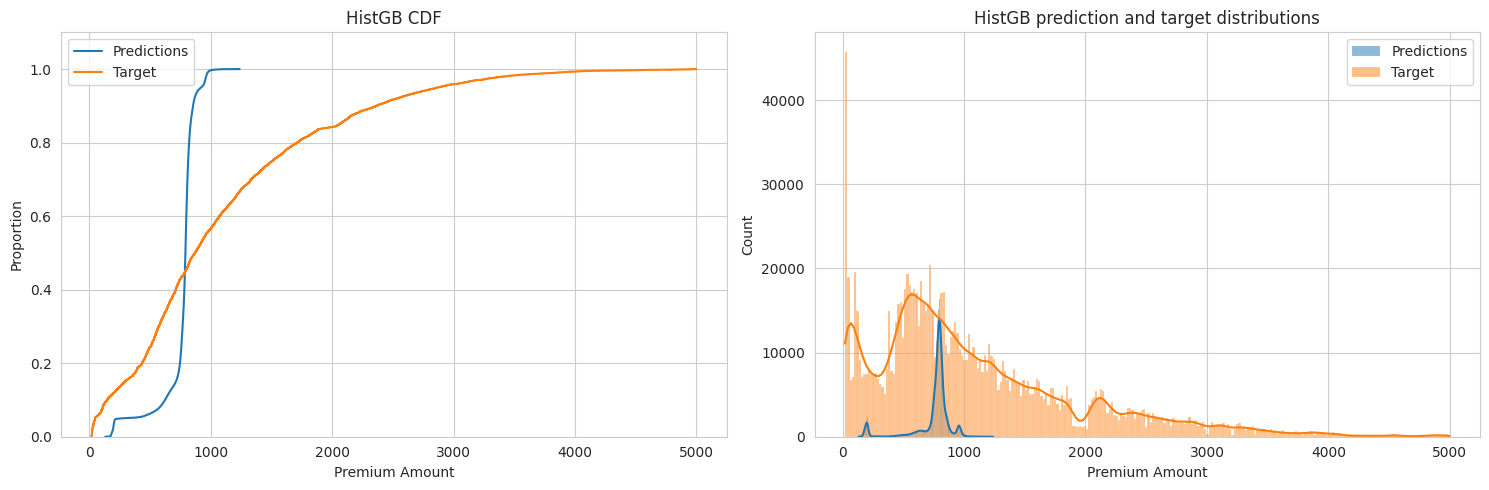

In [11]:
plot_results(oof_preds["HistGB"], y, "HistGB")

## LightGBM (GBDT)

In [12]:
X, y, X_test = get_data("lgbm-gbdt")
lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
oof_preds["LightGBM"], test_preds["LightGBM"], scores["LightGBM"], _ = lgbm_trainer.train(X, y, X_test, "lgbm-gbdt")

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.04576	valid_0's l2: 1.09362
Early stopping, best iteration is:
[176]	valid_0's rmse: 1.04573	valid_0's l2: 1.09355

--- Fold 1 - RMSLE: 1.045729


Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.04615	valid_0's l2: 1.09443
Early stopping, best iteration is:
[228]	valid_0's rmse: 1.04614	valid_0's l2: 1.09441

--- Fold 2 - RMSLE: 1.046141


Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.04764	valid_0's l2: 1.09754
Early stopping, best iteration is:
[176]	valid_0's rmse: 1.04762	valid_0's l2: 1.0975

--- Fold 3 - RMSLE: 1.047615


Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.04297	valid_0's l2: 1.08778
Early stopping, best iteration is:
[185]	valid_0's rmse: 1.04295	valid_0's l2: 1.08775

--- Fold 4 - RMSLE: 1.042950


Training until validation scores don't improv

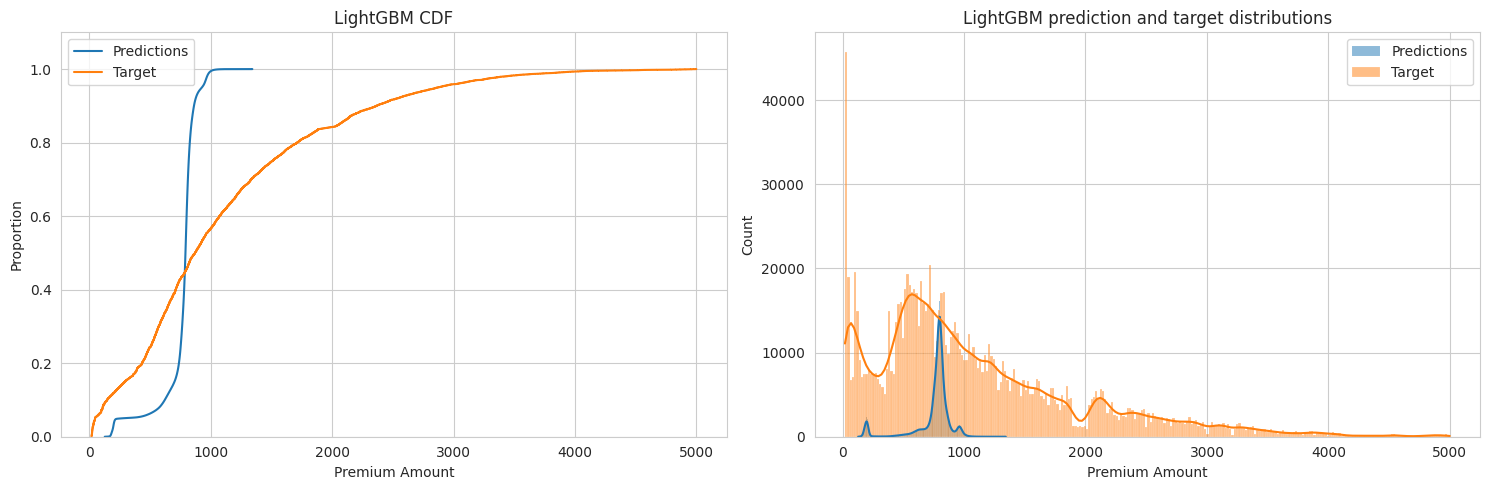

In [13]:
plot_results(oof_preds["LightGBM"], y, "LightGBM")

## LightGBM (GOSS)

In [14]:
X, y, X_test = get_data("lgbm-goss")
lgbm_goss_model = LGBMRegressor(**lgbm_goss_params)
lgbm_goss_trainer = Trainer(lgbm_goss_model)
oof_preds["LightGBM (goss)"], test_preds["LightGBM (goss)"], scores["LightGBM (goss)"], _ = lgbm_goss_trainer.train(X, y, X_test, "lgbm-goss")

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.04745	valid_0's l2: 1.09715
[400]	valid_0's rmse: 1.04594	valid_0's l2: 1.09399
[600]	valid_0's rmse: 1.04577	valid_0's l2: 1.09363
[800]	valid_0's rmse: 1.04571	valid_0's l2: 1.09351
[1000]	valid_0's rmse: 1.04565	valid_0's l2: 1.09339
[1200]	valid_0's rmse: 1.04564	valid_0's l2: 1.09336
Early stopping, best iteration is:
[1298]	valid_0's rmse: 1.04562	valid_0's l2: 1.09331

--- Fold 1 - RMSLE: 1.045616


Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.04785	valid_0's l2: 1.098
[400]	valid_0's rmse: 1.04645	valid_0's l2: 1.09507
[600]	valid_0's rmse: 1.04635	valid_0's l2: 1.09484
[800]	valid_0's rmse: 1.04633	valid_0's l2: 1.0948
Early stopping, best iteration is:
[741]	valid_0's rmse: 1.04631	valid_0's l2: 1.09477

--- Fold 2 - RMSLE: 1.046311


Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.04915	va

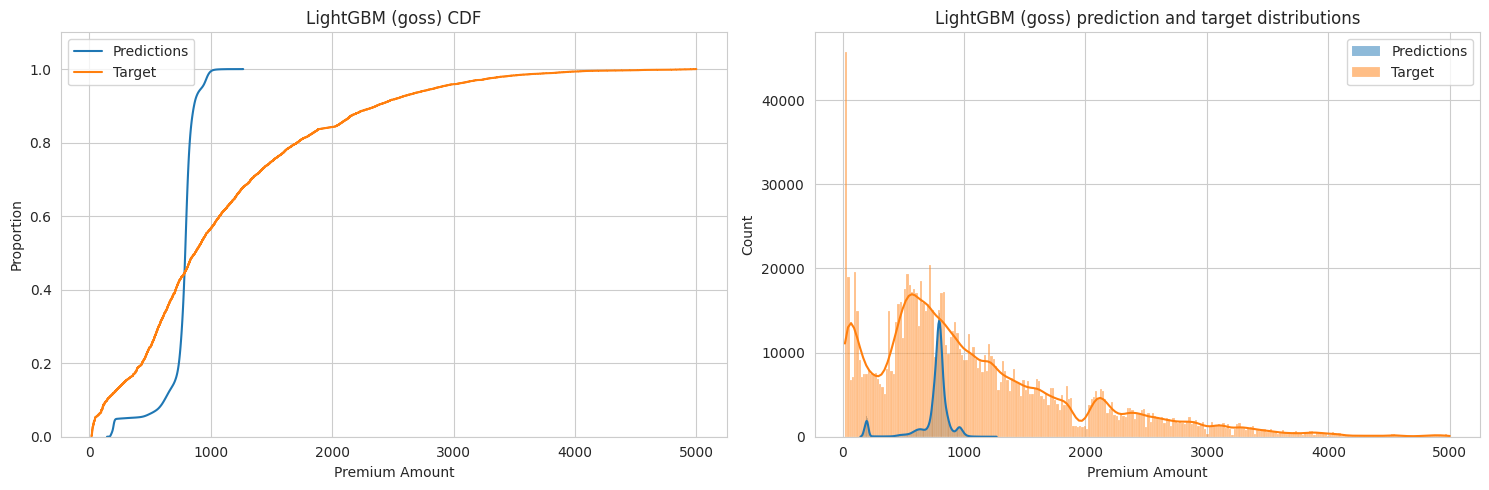

In [15]:
plot_results(oof_preds["LightGBM (goss)"], y, "LightGBM (goss)")

## XGBoost

In [16]:
X, y, X_test = get_data("xgb")
xgb_model = XGBRegressor(**xgb_params)
xgb_trainer = Trainer(xgb_model)
oof_preds["XGBoost"], test_preds["XGBoost"], scores["XGBoost"], _ = xgb_trainer.train(X, y, X_test, "xgb")

Training XGBRegressor

[0]	validation_0-rmse:1.09248
[200]	validation_0-rmse:1.04567
[400]	validation_0-rmse:1.04566
[494]	validation_0-rmse:1.04566

--- Fold 1 - RMSLE: 1.045659


[0]	validation_0-rmse:1.09303
[200]	validation_0-rmse:1.04617
[304]	validation_0-rmse:1.04617

--- Fold 2 - RMSLE: 1.046172


[0]	validation_0-rmse:1.09395
[200]	validation_0-rmse:1.04745
[400]	validation_0-rmse:1.04744
[600]	validation_0-rmse:1.04744
[624]	validation_0-rmse:1.04744

--- Fold 3 - RMSLE: 1.047435


[0]	validation_0-rmse:1.08911
[200]	validation_0-rmse:1.04288
[274]	validation_0-rmse:1.04288

--- Fold 4 - RMSLE: 1.042880


[0]	validation_0-rmse:1.09290
[200]	validation_0-rmse:1.04769
[400]	validation_0-rmse:1.04768
[438]	validation_0-rmse:1.04769

--- Fold 5 - RMSLE: 1.047684


[0]	validation_0-rmse:1.09010
[200]	validation_0-rmse:1.04428
[251]	validation_0-rmse:1.04428

--- Fold 6 - RMSLE: 1.044273


[0]	validation_0-rmse:1.09079
[200]	validation_0-rmse:1.04327
[367]	validation_0-rmse:1.04327

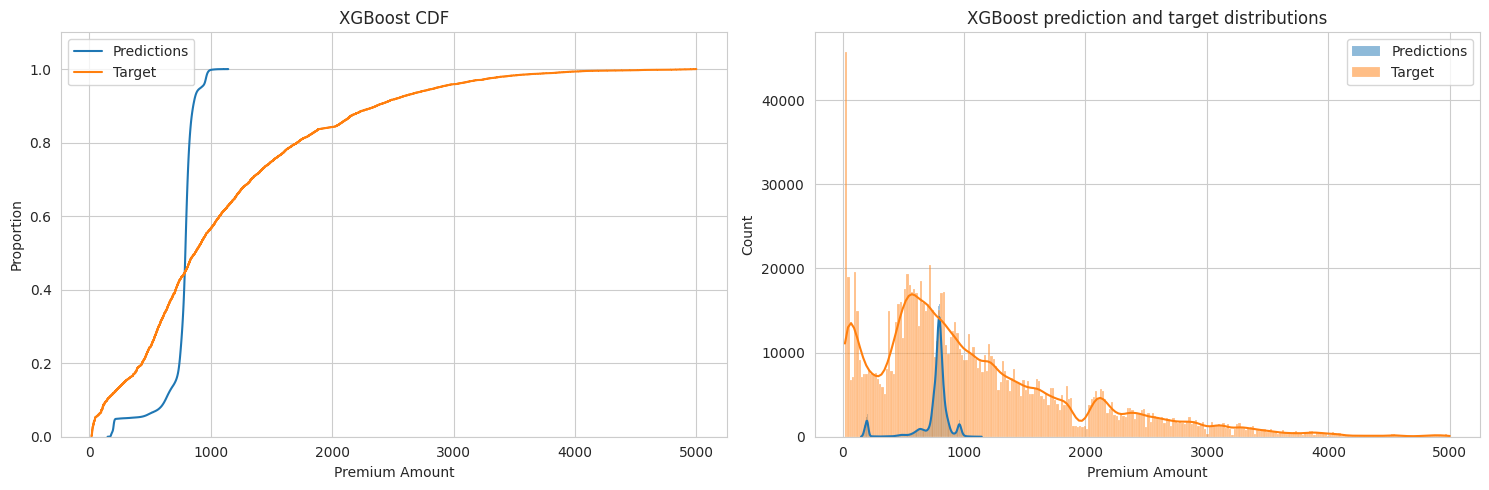

In [17]:
plot_results(oof_preds["XGBoost"], y, "XGBoost")

## CatBoost

In [18]:
X, y, X_test = get_data("cb")
cb_model = CatBoostRegressor(**cb_params)
cb_trainer = Trainer(cb_model)
oof_preds["CatBoost"], test_preds["CatBoost"], scores["CatBoost"], _ = cb_trainer.train(X, y, X_test, "cb")

Training CatBoostRegressor

0:	learn: 1.0896586	test: 1.0901102	best: 1.0901102 (0)	total: 1.55s	remaining: 2h 8m 53s
200:	learn: 1.0461285	test: 1.0476138	best: 1.0476138 (200)	total: 3m 5s	remaining: 1h 13m 54s
400:	learn: 1.0448777	test: 1.0470979	best: 1.0470979 (400)	total: 6m 29s	remaining: 1h 14m 26s
600:	learn: 1.0434427	test: 1.0469068	best: 1.0469033 (590)	total: 10m 4s	remaining: 1h 13m 43s
800:	learn: 1.0419099	test: 1.0468251	best: 1.0468209 (788)	total: 13m 48s	remaining: 1h 12m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.046818369
bestIteration = 805

Shrink model to first 806 iterations.

--- Fold 1 - RMSLE: 1.046818


0:	learn: 1.0896401	test: 1.0905890	best: 1.0905890 (0)	total: 1.28s	remaining: 1h 46m 51s
200:	learn: 1.0461216	test: 1.0481452	best: 1.0481452 (200)	total: 3m 4s	remaining: 1h 13m 30s
400:	learn: 1.0447784	test: 1.0475530	best: 1.0475530 (400)	total: 6m 15s	remaining: 1h 11m 47s
600:	learn: 1.0434147	test: 1.0473259	best: 1.

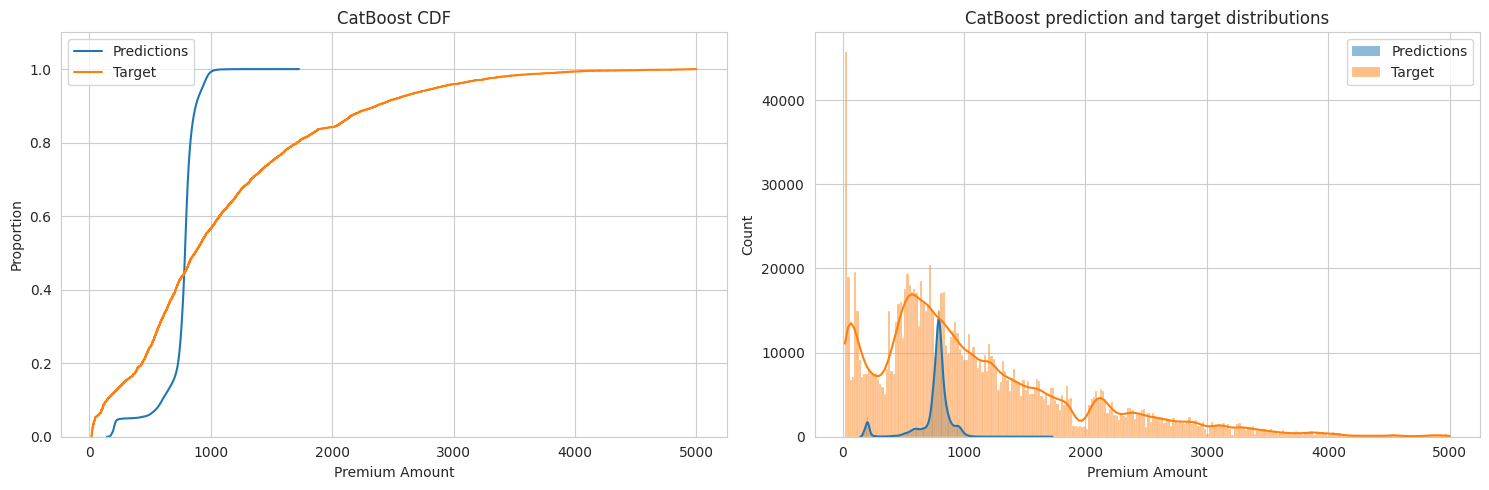

In [19]:
plot_results(oof_preds["CatBoost"], y, "CatBoost")

## Yggdrasil Decision Forests

In [20]:
# Reference: https://www.kaggle.com/competitions/playground-series-s4e12/discussion/549959#3064621

def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [21]:
# Reference: https://www.kaggle.com/competitions/playground-series-s4e12/discussion/549959#3064621

X, y, X_test = get_data("ydf")
ydf_model = YDFRegressor(GradientBoostedTreesLearner)(ydf_params)
ydf_trainer = Trainer(ydf_model)
oof_preds["Yggdrasil DF"], test_preds["Yggdrasil DF"], scores["Yggdrasil DF"], _ = ydf_trainer.train(X, y, X_test, "ydf")

Training YDFXRegressor

--- Fold 1 - RMSLE: 1.046298
--- Fold 2 - RMSLE: 1.046769
--- Fold 3 - RMSLE: 1.047550
--- Fold 4 - RMSLE: 1.043199
--- Fold 5 - RMSLE: 1.047941
--- Fold 6 - RMSLE: 1.044423
--- Fold 7 - RMSLE: 1.043312
--- Fold 8 - RMSLE: 1.044899
--- Fold 9 - RMSLE: 1.042470
--- Fold 10 - RMSLE: 1.049641

------ Overall RMSLE: 1.045653 - Average RMSLE: 1.045650


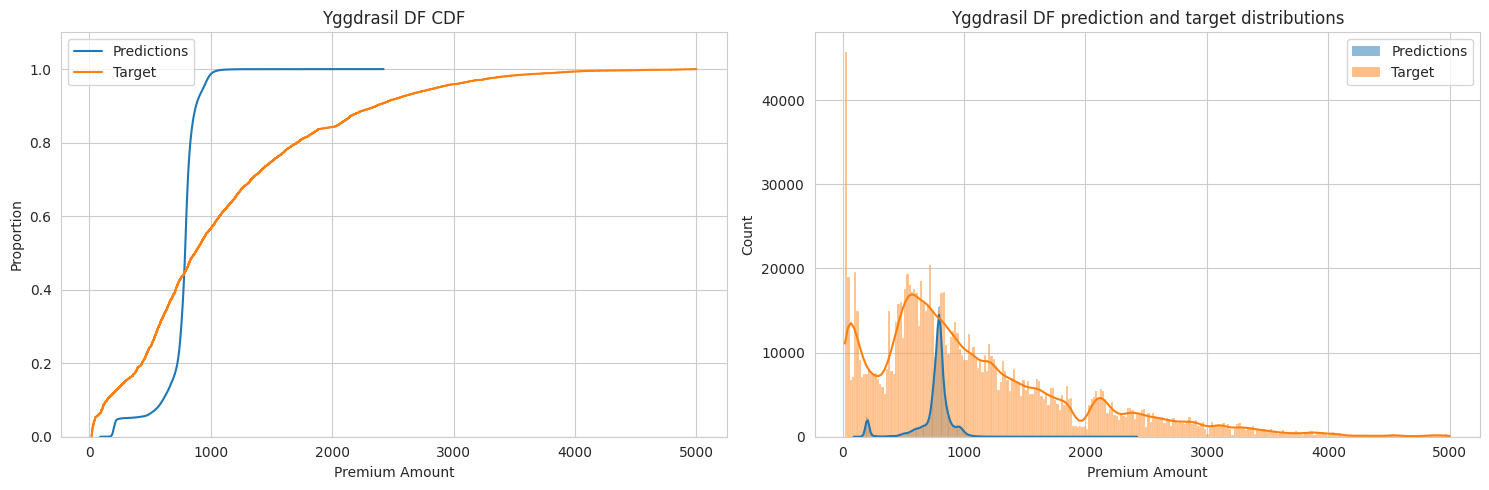

In [22]:
plot_results(oof_preds["Yggdrasil DF"], y, "Yggdrasil DF")

## AutoGluon

In [23]:
oof_preds_files = glob.glob(f'/kaggle/input/s04e12-insurance-premium-prediction-autogluon/*_oof_preds_*.pkl')
test_preds_files = glob.glob(f'/kaggle/input/s04e12-insurance-premium-prediction-autogluon/*_test_preds_*.pkl')

ag_oof_preds = np.log1p(pickle.load(open(oof_preds_files[0], 'rb')))
ag_test_preds = np.log1p(pickle.load(open(test_preds_files[0], 'rb')))

ag_scores = []
split = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(X, y)
for _, val_idx in split:
    y_val = y[val_idx]
    y_preds = ag_oof_preds[val_idx]   
    score = root_mean_squared_error(y_preds, y_val)
    ag_scores.append(score)
    
oof_preds["AutoGluon"], test_preds["AutoGluon"], scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_scores

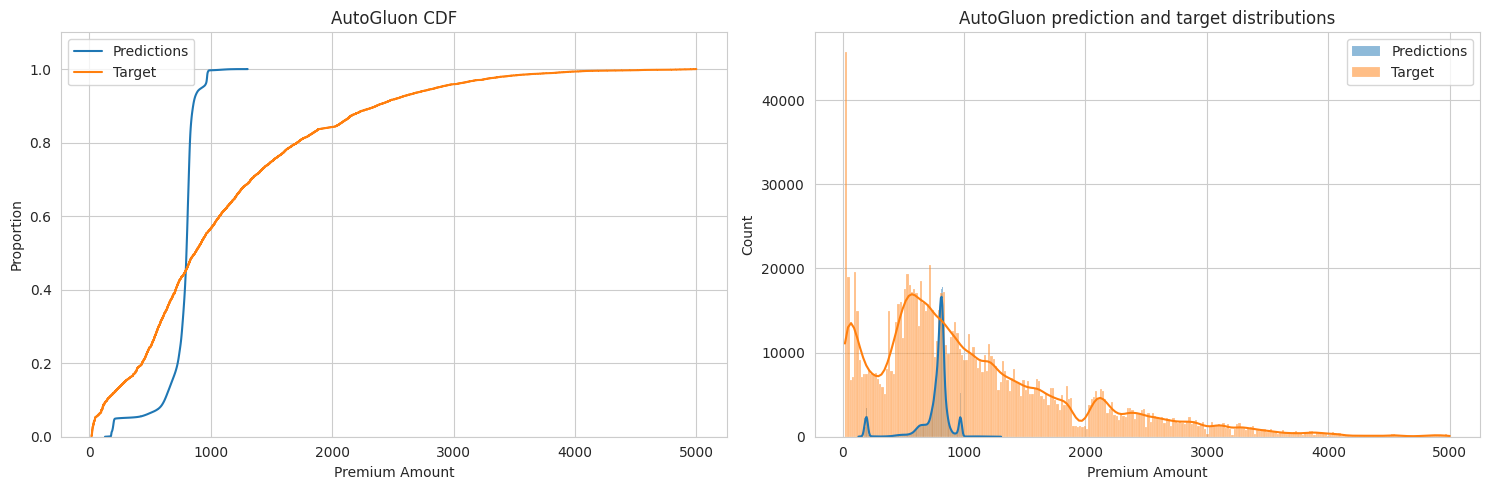

In [24]:
plot_results(oof_preds["AutoGluon"], y, "AutoGluon")

# L2 Ridge

In [25]:
l2_oof_preds = {}
l2_test_preds = {}

In [26]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [27]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [28]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'alpha': trial.suggest_float('alpha', 0, 50),
        'tol': trial.suggest_float('tol', 1e-6, 1e-3)
    }
    
    model = Ridge(**params)
    trainer = Trainer(model)
    return trainer.tune(X, y)

sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1)
best_params = study.best_params

[I 2024-12-31 20:15:16,323] A new study created in memory with name: no-name-7bf68c7d-771f-41a3-9d8a-587d4135c8ae
[I 2024-12-31 20:15:30,696] Trial 3 finished with value: 1.0442273159136726 and parameters: {'alpha': 26.530951220592435, 'tol': 0.0007315454560072024}. Best is trial 3 with value: 1.0442273159136726.
[I 2024-12-31 20:15:30,880] Trial 0 finished with value: 1.0442273389208758 and parameters: {'alpha': 17.96535688205519, 'tol': 0.0009551849506475231}. Best is trial 3 with value: 1.0442273159136726.
[I 2024-12-31 20:15:31,061] Trial 1 finished with value: 1.04422731847772 and parameters: {'alpha': 24.186024251511423, 'tol': 0.00017899714769185386}. Best is trial 3 with value: 1.0442273159136726.
[I 2024-12-31 20:15:31,285] Trial 2 finished with value: 1.044227318522005 and parameters: {'alpha': 24.15986292587387, 'tol': 1.6921725316392436e-06}. Best is trial 3 with value: 1.0442273159136726.
[I 2024-12-31 20:15:44,842] Trial 4 finished with value: 1.0442273166370513 and param

In [29]:
ridge_params = {
    'random_state': CFG.seed,
    'alpha': best_params['alpha'],
    'tol': best_params['tol']
}
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 27.63601863114376,
  "tol": 0.0008637940664605286
}


In [30]:
ridge_model = Ridge(**ridge_params)
ridge_trainer = Trainer(ridge_model)
l2_oof_preds["L2 Ensemble Ridge"], l2_test_preds["L2 Ensemble Ridge"], scores["L2 Ensemble Ridge"], ridge_coeffs = ridge_trainer.train(X, y, X_test, "ensemble-ridge")

Training Ridge

--- Fold 1 - RMSLE: 1.044819
--- Fold 2 - RMSLE: 1.044859
--- Fold 3 - RMSLE: 1.046237
--- Fold 4 - RMSLE: 1.041841
--- Fold 5 - RMSLE: 1.046698
--- Fold 6 - RMSLE: 1.043156
--- Fold 7 - RMSLE: 1.042184
--- Fold 8 - RMSLE: 1.043574
--- Fold 9 - RMSLE: 1.040778
--- Fold 10 - RMSLE: 1.048128

------ Overall RMSLE: 1.044230 - Average RMSLE: 1.044227


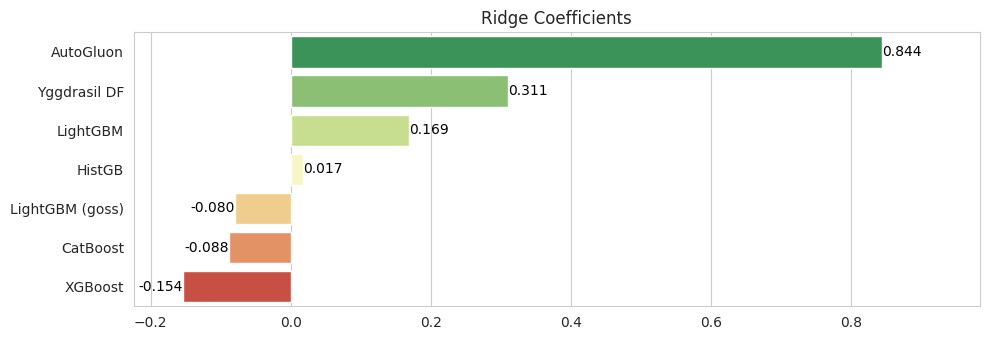

In [31]:
plot_weights(ridge_coeffs, "Ridge Coefficients")

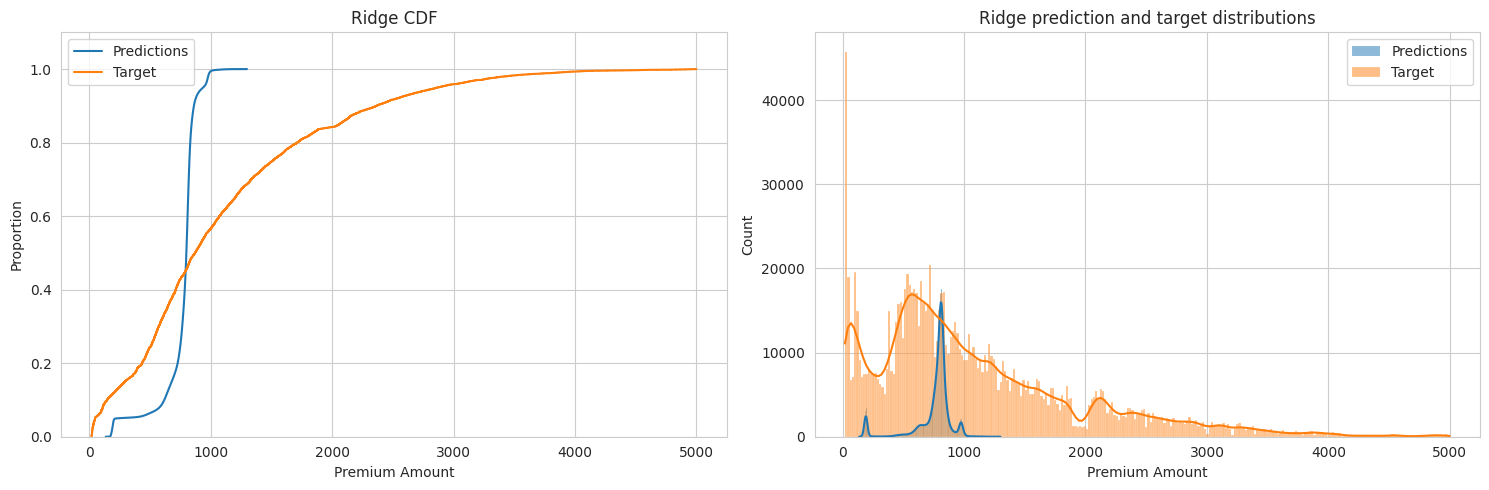

In [32]:
plot_results(l2_oof_preds["L2 Ensemble Ridge"], y, "Ridge")

In [33]:
save_sub("l2-ensemble-ridge", l2_test_preds["L2 Ensemble Ridge"], np.mean(scores["L2 Ensemble Ridge"]))

,id,Premium Amount
0,1200000,844.530565
1,1200001,820.544938
2,1200002,802.890045
3,1200003,818.275903
4,1200004,741.883625
...,...,...
799995,1999995,984.630387
799996,1999996,544.665092
799997,1999997,823.480491
799998,1999998,825.852445


# L2 Lasso

In [34]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [35]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'alpha': trial.suggest_float('alpha', 1e-7, 1e-3),
        'tol': trial.suggest_float('tol', 1e-6, 1e-3)
    }
    
    model = Lasso(**params)
    trainer = Trainer(model)
    return trainer.tune(X, y)

sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1)
best_params = study.best_params

[I 2024-12-31 20:22:01,005] A new study created in memory with name: no-name-3628c23d-153e-4b79-af32-cca5603b5a32
[I 2024-12-31 20:23:31,928] Trial 0 finished with value: 1.044261732033008 and parameters: {'alpha': 0.000984281562472613, 'tol': 0.0006812317184638871}. Best is trial 0 with value: 1.044261732033008.
[I 2024-12-31 20:23:49,030] Trial 1 finished with value: 1.044250558557483 and parameters: {'alpha': 0.00013842424073663722, 'tol': 0.0009585780272214456}. Best is trial 1 with value: 1.044250558557483.
[I 2024-12-31 20:23:49,751] Trial 3 finished with value: 1.04425644536404 and parameters: {'alpha': 0.00017572822126633102, 'tol': 0.0003697755949070829}. Best is trial 1 with value: 1.044250558557483.
[I 2024-12-31 20:23:50,221] Trial 2 finished with value: 1.0442579814842532 and parameters: {'alpha': 0.0003962125303661952, 'tol': 3.994356275011837e-05}. Best is trial 1 with value: 1.044250558557483.
[I 2024-12-31 20:25:06,621] Trial 4 finished with value: 1.0442585701166314 a

In [36]:
lasso_params = {
    'random_state': CFG.seed,
    'alpha': best_params['alpha'],
    'tol': best_params['tol']
}
print(json.dumps(lasso_params, indent=2))

{
  "random_state": 42,
  "alpha": 3.858704516563345e-06,
  "tol": 0.0006216458974700566
}


In [37]:
lasso_model = Lasso(**lasso_params)
lasso_trainer = Trainer(lasso_model)
l2_oof_preds["L2 Ensemble Lasso"], l2_test_preds["L2 Ensemble Lasso"], scores["L2 Ensemble Lasso"], lasso_coeffs = lasso_trainer.train(X, y, X_test, "ensemble-ridge")

Training Lasso

--- Fold 1 - RMSLE: 1.044821
--- Fold 2 - RMSLE: 1.044855
--- Fold 3 - RMSLE: 1.046234
--- Fold 4 - RMSLE: 1.041843
--- Fold 5 - RMSLE: 1.046696
--- Fold 6 - RMSLE: 1.043153
--- Fold 7 - RMSLE: 1.042186
--- Fold 8 - RMSLE: 1.043577
--- Fold 9 - RMSLE: 1.040779
--- Fold 10 - RMSLE: 1.048130

------ Overall RMSLE: 1.044230 - Average RMSLE: 1.044227


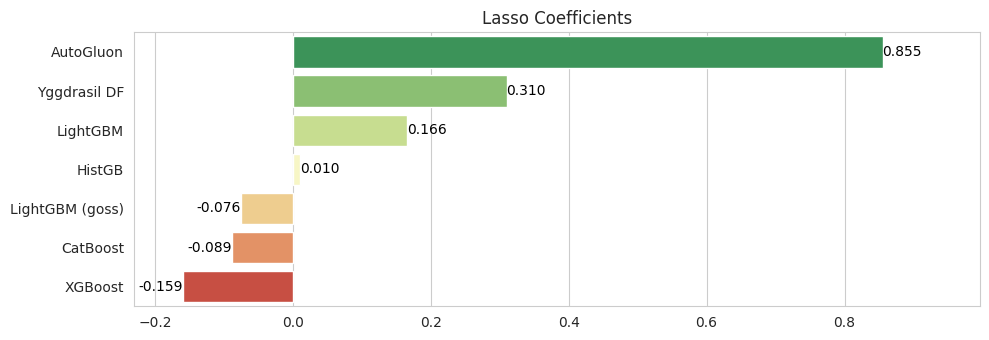

In [38]:
plot_weights(lasso_coeffs, "Lasso Coefficients")

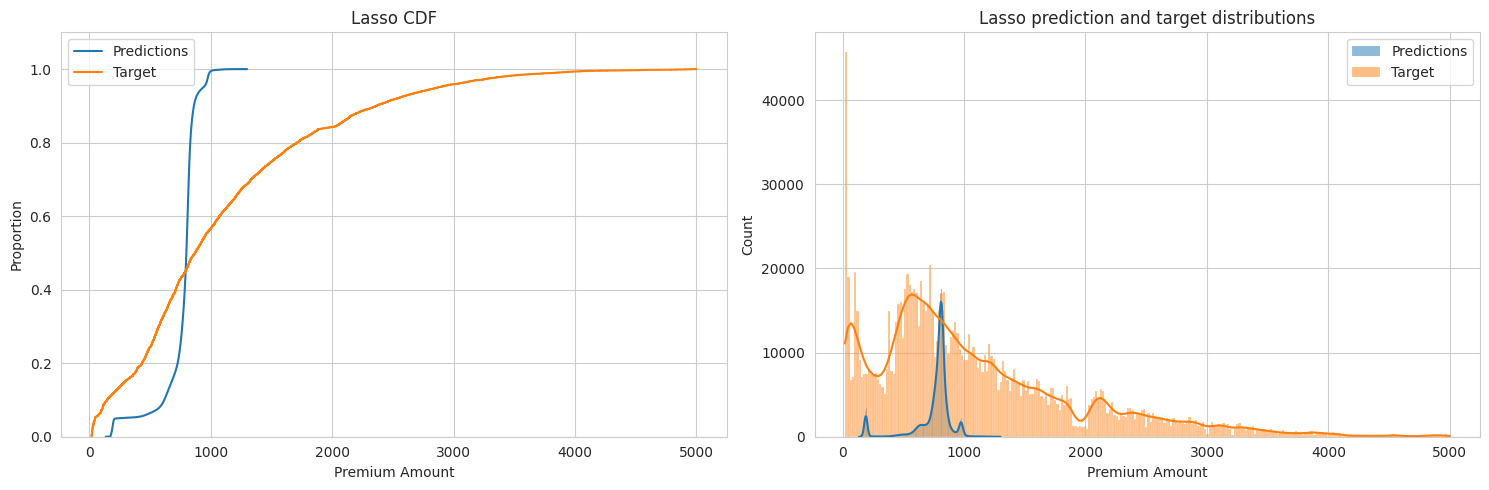

In [39]:
plot_results(l2_oof_preds["L2 Ensemble Lasso"], y, "Lasso")

In [40]:
save_sub("l2-ensemble-lasso", l2_test_preds["L2 Ensemble Lasso"], np.mean(scores["L2 Ensemble Lasso"]))

,id,Premium Amount
0,1200000,844.244992
1,1200001,820.794652
2,1200002,803.052723
3,1200003,818.421176
4,1200004,741.681041
...,...,...
799995,1999995,984.608297
799996,1999996,544.259174
799997,1999997,823.516966
799998,1999998,825.907435


# L3 weighted ensemble

In [41]:
def objective(trial):
    weights = np.array([trial.suggest_float(l2_model_name, 0, 1) for l2_model_name in l2_oof_preds.keys()])
    weights /= np.sum(weights)
    
    preds = np.zeros(len(y))
    for model, weight in zip(l2_oof_preds.keys(), weights):
        preds += l2_oof_preds[model] * weight
            
    return root_mean_squared_error(y, preds)

sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=CFG.n_optuna_trials * 2, n_jobs=-1)

[I 2024-12-31 23:00:16,018] A new study created in memory with name: no-name-ae98ef27-732f-457c-9c3a-d28c2116c600
[I 2024-12-31 23:00:16,082] Trial 0 finished with value: 1.044229719615334 and parameters: {'L2 Ensemble Ridge': 0.9017563615492831, 'L2 Ensemble Lasso': 0.9722474611356741}. Best is trial 0 with value: 1.044229719615334.
[I 2024-12-31 23:00:16,086] Trial 1 finished with value: 1.0442297126572808 and parameters: {'L2 Ensemble Ridge': 0.9031786375897964, 'L2 Ensemble Lasso': 0.7739057061389546}. Best is trial 1 with value: 1.0442297126572808.
[I 2024-12-31 23:00:16,087] Trial 2 finished with value: 1.0442297168769175 and parameters: {'L2 Ensemble Ridge': 0.8893776677944537, 'L2 Ensemble Lasso': 0.8785745070810265}. Best is trial 1 with value: 1.0442297126572808.
[I 2024-12-31 23:00:16,111] Trial 3 finished with value: 1.0442296841295768 and parameters: {'L2 Ensemble Ridge': 0.8294569998064548, 'L2 Ensemble Lasso': 0.045887044698501134}. Best is trial 3 with value: 1.04422968

In [42]:
scores['L3 Weighted Ensemble'] = [study.best_value] * CFG.n_folds

In [43]:
best_weights = np.array([study.best_params[l2_model] for l2_model in l2_oof_preds.keys()])
best_weights /= np.sum(best_weights)
print(json.dumps({model: weight for model, weight in zip(l2_oof_preds.keys(), best_weights)}, indent=2))

{
  "L2 Ensemble Ridge": 0.9999621326681073,
  "L2 Ensemble Lasso": 3.786733189265247e-05
}


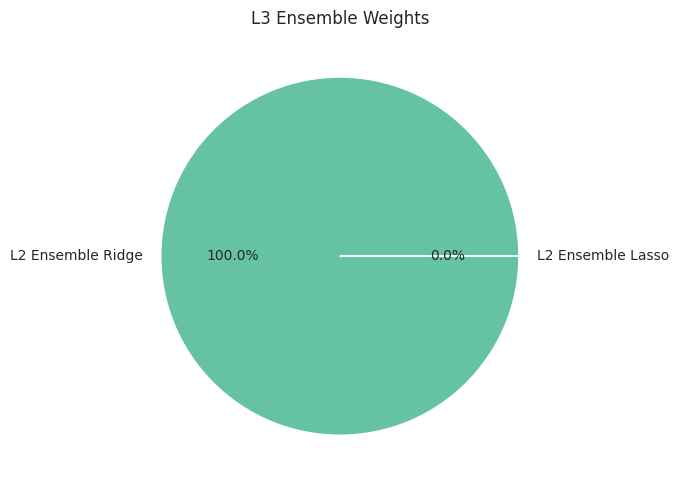

In [44]:
plt.figure(figsize=(8, 5))
plt.pie(
    study.best_params.values(), 
    labels=study.best_params.keys(), 
    autopct='%1.1f%%',
    colors=sns.color_palette('Set2', 2)
)
plt.title("L3 Ensemble Weights")
plt.tight_layout()
plt.show()

In [45]:
weighted_test_preds = np.zeros((X_test.shape[0]))
for model, weight in zip(l2_test_preds.keys(), best_weights):
    weighted_test_preds += l2_test_preds[model] * weight
    
save_sub('l3-weighted-ensemble', weighted_test_preds, np.mean(scores['L3 Weighted Ensemble']))

,id,Premium Amount
0,1200000,844.530554
1,1200001,820.544947
2,1200002,802.890051
3,1200003,818.275908
4,1200004,741.883617
...,...,...
799995,1999995,984.630387
799996,1999996,544.665077
799997,1999997,823.480492
799998,1999998,825.852447


# Results

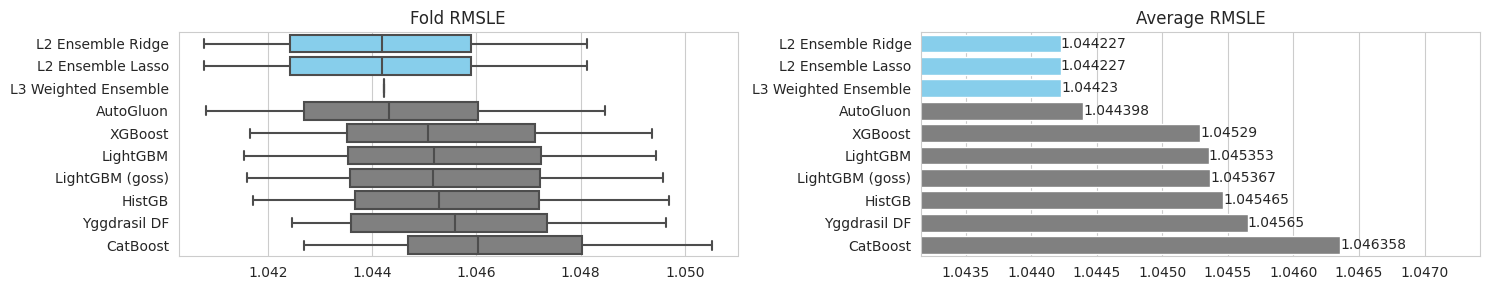

In [46]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "skyblue" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

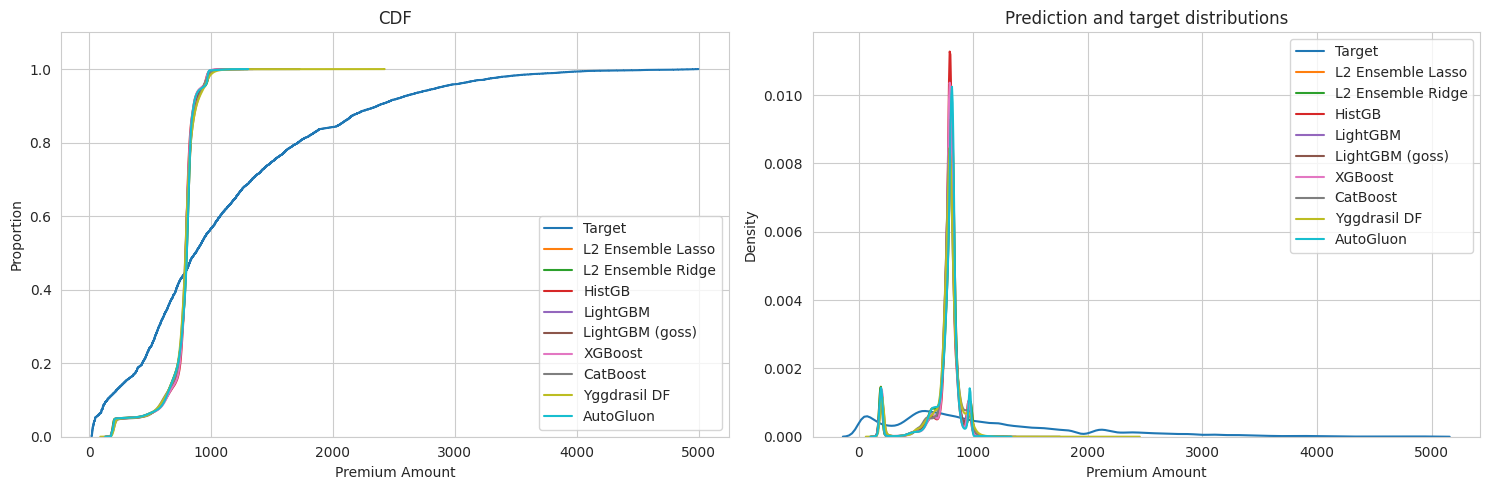

In [47]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.ecdfplot(np.expm1(y), label="Target", ax=axes[0])
sns.ecdfplot(np.expm1(l2_oof_preds["L2 Ensemble Lasso"]), label="L2 Ensemble Lasso", ax=axes[0])
sns.ecdfplot(np.expm1(l2_oof_preds["L2 Ensemble Ridge"]), label="L2 Ensemble Ridge", ax=axes[0])
for model in oof_preds:
    sns.ecdfplot(np.expm1(oof_preds[model]), label=model, ax=axes[0])
axes[0].set_title("CDF")
axes[0].legend(loc="best")
axes[0].set_ylim(0, 1.1)

sns.kdeplot(np.expm1(y), ax=axes[1], label='Target')
sns.kdeplot(np.expm1(l2_oof_preds["L2 Ensemble Lasso"]), ax=axes[1], label='L2 Ensemble Lasso')
sns.kdeplot(np.expm1(l2_oof_preds["L2 Ensemble Ridge"]), ax=axes[1], label='L2 Ensemble Ridge')
for model in oof_preds:
    sns.kdeplot(np.expm1(oof_preds[model]), ax=axes[1], label=model)
axes[1].set_title("Prediction and target distributions")
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

In [48]:
shutil.rmtree("catboost_info", ignore_errors=True)